<a href="https://colab.research.google.com/github/iskra3138/colab_repo/blob/master/images_TF_Official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial provides a simple example of how to load an image dataset using `tf.data`.

The dataset used in this example is distributed as directories of images, with one class of image per directory.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
tf.__version__

'2.1.0'

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [0]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

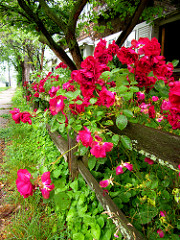

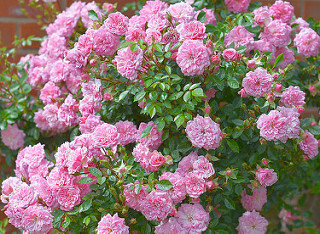

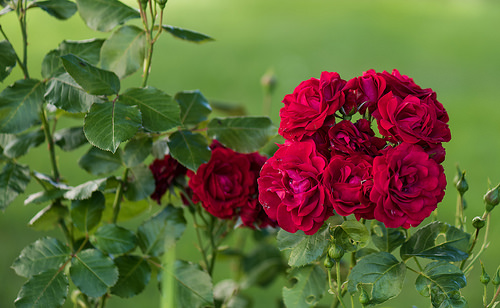

In [9]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [13]:
# `keras.preprocessing`
timeit(train_data_gen)

10000000 loops, best of 3: 24.8 ns per loop


Inspect a batch:

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

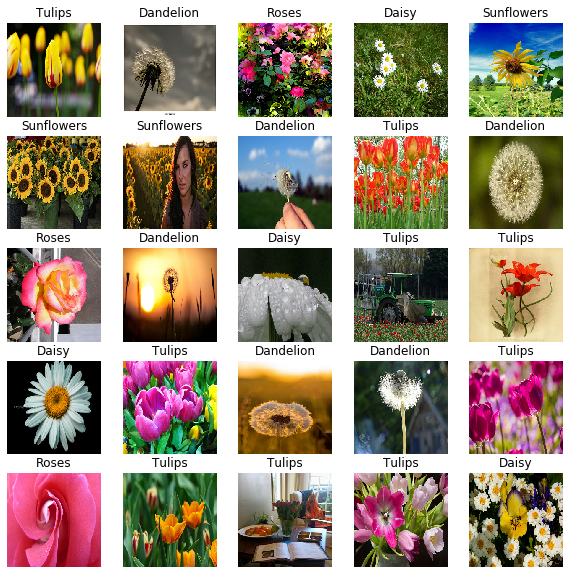

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [16]:
print(image_batch.dtype, image_batch.shape)
print(label_batch.dtype, label_batch.shape)

float32 (32, 224, 224, 3)
float32 (32, 5)


## Load using `tf.data` using python generator_추가

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
#image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [18]:
'''
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))
'''

'\ntrain_data_gen = image_generator.flow_from_directory(directory=str(data_dir),\n                                                     batch_size=BATCH_SIZE,\n                                                     shuffle=True,\n                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),\n                                                     classes = list(CLASS_NAMES))\n'

In [19]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(str(data_dir),
            batch_size=BATCH_SIZE,
            shuffle=True,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            classes = list(CLASS_NAMES)),
    output_types=(tf.float32, tf.float32),
    output_shapes = ([None,224,224,3],[None,5])
)

ds

<FlatMapDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.float32)>

In [20]:
print (ds.repeat().batch(10).take(10))

<TakeDataset shapes: ((None, None, 224, 224, 3), (None, None, 5)), types: (tf.float32, tf.float32)>


In [21]:
for x, y in ds.repeat().batch(10).take(1):
  print (x,y)

Found 3670 images belonging to 5 classes.
tf.Tensor(
[[[[[0.91372555 0.654902   0.07450981]
    [0.9215687  0.6666667  0.10196079]
    [0.9215687  0.68235296 0.13333334]
    ...
    [0.3019608  0.25882354 0.14117648]
    [0.28627452 0.2509804  0.13725491]
    [0.26666668 0.2392157  0.1254902 ]]

   [[0.909804   0.64705884 0.05490196]
    [0.9176471  0.65882355 0.08627451]
    [0.9176471  0.6745098  0.1137255 ]
    ...
    [0.29411766 0.25882354 0.13725491]
    [0.2784314  0.24313727 0.12941177]
    [0.27058825 0.23529413 0.12156864]]

   [[0.91372555 0.6431373  0.04313726]
    [0.9176471  0.654902   0.07058824]
    [0.9176471  0.6627451  0.09803922]
    ...
    [0.29803923 0.25490198 0.13725491]
    [0.29411766 0.2509804  0.14117648]
    [0.28235295 0.24705884 0.13333334]]

   ...

   [[0.5803922  0.47450984 0.13333334]
    [0.5882353  0.48235297 0.14117648]
    [0.59607846 0.4901961  0.14117648]
    ...
    [0.6666667  0.50980395 0.1764706 ]
    [0.6431373  0.48235297 0.16862746]
    

## Make TFRecord

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [23]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/3661675690_ed2d05fa5f_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/113902743_8f537f769b_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/434146736_310a42d9cb_m.jpg'
b'/root/.keras/datasets/flower_photos/roses/4061451210_1650590c6a.jpg'
b'/root/.keras/datasets/flower_photos/tulips/6799076717_575944af91_m.jpg'


In [0]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

#### file 1개로 TFRecord 만들기

In [0]:
def image_example(file_path):
  image_string = open(file_path, 'rb').read()
  image_shape = tf.image.decode_jpeg(image_string).shape
  
  parts = tf.strings.split(file_path, os.path.sep)
  label = tf.where(CLASS_NAMES == parts[-2])[0][0]

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

In [0]:
file_path=b'/root/.keras/datasets/flower_photos/sunflowers/15054865768_2cc87ac9d4_m.jpg'

In [0]:
record_file = 'tmp.tfrecords'

with tf.io.TFRecordWriter(record_file) as writer:
  tf_example = image_example(file_path)
  writer.write(tf_example.SerializeToString())

TFRecord 읽기

In [0]:
dataset = tf.data.TFRecordDataset(filenames = 'tmp.tfrecords')

In [66]:
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [67]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['label']

int64_list {
  value: 3
}

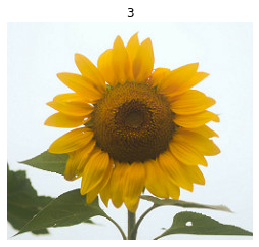

In [69]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image_raw'].bytes_list.value[0]
img = tf.image.decode_jpeg(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["label"].int64_list.value[0])

In [127]:
raw_image_dataset = tf.data.TFRecordDataset('tmp.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], image_feature_description)
  return example['image_raw'][0], example['label'][0]

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: ((), ()), types: (tf.string, tf.int64)>

출처: https://www.tensorflow.org/guide/data

In [144]:
raw_image_dataset = tf.data.TFRecordDataset('tmp.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], image_feature_description)
  return example
  #return example['image_raw'][0], example['label'][0]

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (1,), height: (1,), image_raw: (1,), label: (1,), width: (1,)}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

In [0]:
result = next(iter(parsed_image_dataset))

In [159]:
print (result['height'][0], result['width'][0], result['depth'][0], result['label'][0])

tf.Tensor(221, shape=(), dtype=int64) tf.Tensor(240, shape=(), dtype=int64) tf.Tensor(3, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


In [160]:
tf.io.decode_jpeg(result['image_raw'][0]).numpy().shape

(221, 240, 3)

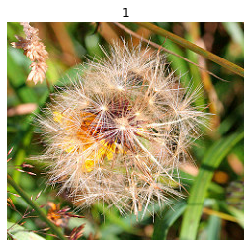

In [161]:
plt.imshow(tf.io.decode_jpeg(result['image_raw'][0]).numpy())
plt.axis('off')
_ = plt.title(result['label'][0].numpy())

In [30]:
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

#### list_ds로 TFRecord만들기

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [0]:
def tf_image_example(file_path):
  image_string = tf.io.read_file(file_path)
  image_shape = tf.image.decode_jpeg(image_string).shape
  
  parts = tf.strings.split(file_path, os.path.sep)
  label = tf.where(CLASS_NAMES == parts[-2])[0][0]

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

In [0]:
record_file = 'tmp.tfrecords'

with tf.io.TFRecordWriter(record_file) as writer:
  for file_path in list_ds:
    tf_example = tf_image_example(file_path)
    writer.write(tf_example.SerializeToString())

list_ds로 만든 TFRecord Parsing하기

In [197]:
raw_image_dataset = tf.data.TFRecordDataset('tmp.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], image_feature_description)
  
  label = example['label'][0]
  label = tf.one_hot(indices=label,
                    depth=5
                    )
  image = tf.io.decode_jpeg(example['image_raw'][0])
  #image = tf.cast(image, tf.float32)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to the desired size.
  image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
  #image /= 255.0
  return image, label
  #return example['image_raw'][0], example['label'][0]

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: ((224, 224, None), (5,)), types: (tf.float32, tf.float32)>

In [0]:
img, label = next(iter(parsed_image_dataset))

In [177]:
print (img)

tf.Tensor(
[[[1.5307300e-03 1.8410502e-03 3.4711926e-04]
  [1.3346515e-03 1.7290055e-03 1.7081342e-04]
  [1.3428901e-03 1.8278685e-03 2.1200636e-04]
  ...
  [8.2056364e-04 1.0748615e-03 3.3009273e-04]
  [1.2819222e-03 1.1847086e-03 5.4429518e-04]
  [1.9162921e-03 1.3923204e-03 7.7662303e-04]]

 [[1.6798130e-03 2.0934688e-03 4.8220885e-04]
  [1.4288375e-03 1.8667860e-03 2.8006913e-04]
  [1.3186708e-03 1.8337888e-03 2.1631202e-04]
  ...
  [7.2530174e-04 8.9886878e-04 2.2944873e-04]
  [8.7719306e-04 8.1227120e-04 2.4720651e-04]
  [1.2903603e-03 9.5691241e-04 3.8750091e-04]]

 [[1.8453093e-03 2.3789322e-03 6.0282694e-04]
  [1.5581724e-03 2.0766421e-03 3.6989921e-04]
  [1.3765679e-03 1.8816867e-03 2.7744798e-04]
  ...
  [8.5818477e-04 8.6924928e-04 2.8259389e-04]
  [7.0911134e-04 6.6714623e-04 1.7953782e-04]
  [7.6897634e-04 6.5601978e-04 2.0487465e-04]]

 ...

 [[1.6577890e-03 1.7241326e-03 9.7501744e-04]
  [1.0622678e-03 1.5758153e-03 2.8670620e-04]
  [1.1671000e-03 1.6245676e-03 3.737298

In [192]:
print (label)

tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)


original code - https://www.tensorflow.org/tutorials/load_data/tfrecord#read_the_tfrecord_file

In [0]:
raw_image_dataset = tf.data.TFRecordDataset('tmp.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)

  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

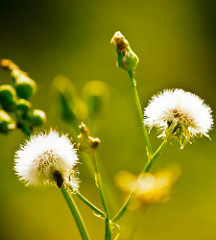

3


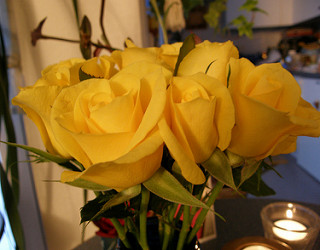

1


In [0]:
for image_features in parsed_image_dataset.take(2):
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))
  #display.display(display.Image(data=image_raw.numpy()))
  #display.display(display.Image(data=image_raw.numpy()))
  print (image_features['label'].numpy())
  #print (label.numpy())

bytes

## Load using `tf.data`

**The above `keras.preprocessing` method is convienient, but has three downsides:** 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [169]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/20596941736_f2c5f496cf.jpg'
b'/root/.keras/datasets/flower_photos/daisy/9299302012_958c70564c_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/5797606814_ccac615312_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/3357432116_b3dce6fed3_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4942258704_c4146b710a_n.jpg'


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [174]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False]


### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [189]:
print (label_batch)

tf.Tensor(
[[False False False  True False]
 [False  True False False False]
 [False False False False  True]
 [False False  True False False]
 [False  True False False False]
 [False  True False False False]
 [False False False  True False]
 [False  True False False False]
 [False False False  True False]
 [False False False False  True]
 [False  True False False False]
 [False False  True False False]
 [ True False False False False]
 [ True False False False False]
 [False False  True False False]
 [False False  True False False]
 [False  True False False False]
 [False False  True False False]
 [ True False False False False]
 [False  True False False False]
 [False False False False  True]
 [False False False  True False]
 [ True False False False False]
 [False False False  True False]
 [False False  True False False]
 [False False False False  True]
 [False False False False  True]
 [False False False False  True]
 [ True False False False False]
 [False False  True False False]

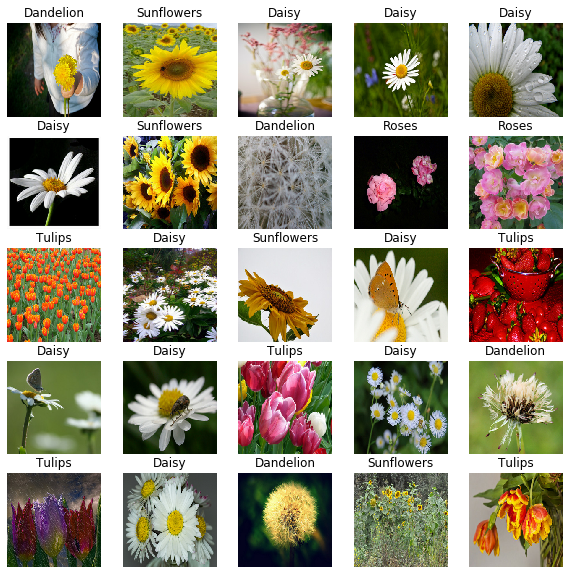

In [181]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](../../guide/performance/datasets).

To investigate, first here's a function to check the performance of our datasets:

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Let's compare the speed of the two data generators:

In [0]:
# `keras.preprocessing`
timeit(train_data_gen)

In [207]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 5.76650857925415 s
5549.28508 Images/s


A large part of the performance gain comes from the use of `.cache`.

In [0]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:

In [0]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

In [0]:
# `keras.preprocessing`
timeit(ds)

In [0]:
ds2 = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(str(data_dir),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        classes = list(CLASS_NAMES)),
    output_types=(tf.float32, tf.float32),
    output_shapes = ([None,IMG_HEIGHT,IMG_WIDTH,3],[None,5])
)

ds2

In [0]:
timeit(ds2.prefetch(buffer_size=AUTOTUNE))

In [0]:
timeit(ds2)

In [0]:
train_tf_ds = prepare_for_training(parsed_image_dataset)

image_batch, label_batch = next(iter(train_tf_ds))

In [199]:
print (label_batch)

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(32, 5), dtype=float32)


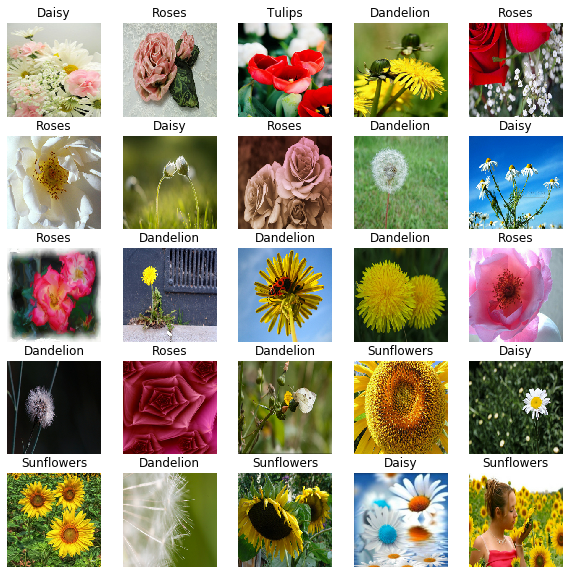

In [200]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [208]:
timeit(train_tf_ds)

....................................................................................................
1000 batches: 5.896298885345459 s
5427.13330 Images/s


### tf.data#2

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
#labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def prepare_for_training2(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()
  
  ds = ds.batch(BATCH_SIZE)
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds2 = prepare_for_training(labeled_ds)



In [0]:
image_batch, label_batch = next(iter(train_ds2))
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
# `tf.data`
timeit(train_ds)

In [0]:
# `tf.data`
timeit(train_ds2)

# augmentation 실험

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      horizontal_flip=True,
      vertical_flip=True,
      rescale=1./255)

Define some parameters for the loader:

In [0]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Inspect a batch:

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`

**The above `keras.preprocessing` method is convienient, but has three downsides:** 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [0]:
for f in list_ds.take(5):
  print(f.numpy())

Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = img / 255.0
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  return img, label

In [0]:
image = np.array([[[1], [2]], [[3], [4]]]) 
x = tf.image.random_flip_left_right(image)

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](../../guide/performance/datasets).

To investigate, first here's a function to check the performance of our datasets:

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Let's compare the speed of the two data generators:

In [0]:
# `keras.preprocessing`
timeit(train_data_gen)

In [0]:
# `tf.data`
timeit(train_ds)

### tf.data#2

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  #img = img / 255.0
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  return img, label

In [0]:
def aug(img, label):
  img = img / 255.0
  return img, label

In [0]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
def prepare_for_training2(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)
  ds = ds.map(aug, num_parallel_calls=AUTOTUNE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds2 = prepare_for_training2(labeled_ds)

In [0]:
# `tf.data`
timeit(train_ds2)

In [0]:
# `tf.data`
timeit(train_ds)

### tf.data#**3**

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  return img, label

In [0]:
def aug(img, label):
  img = img / 255.0
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
#labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def prepare_for_training3(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
  
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)
  
  ds = ds.map(aug, num_parallel_calls=AUTOTUNE)
  
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds3 = prepare_for_training3(list_ds)

In [0]:
# `tf.data`
timeit(train_ds3)